In [1]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Embedding,Flatten
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.optimizers import Adam

import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import emoji
from livelossplot.inputs.tf_keras import PlotLossesCallback

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8546395664580744920
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5771296768
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9609792433368906519
physical_device_desc: "device: 0, name: GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        #tf.config.experimental.set_visible_devices([], 'GPU')
        #tf.debugging.set_log_device_placement(True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
        

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


In [3]:
emb_dim=50
batchsize=32
stepsize = 10
classN=5
map_fn = tf.map_fn

In [4]:
def get_max_sentence_size(allText):
    maxWords=0
    
    for line in allText:
        if(maxWords<len(line.split())):
            maxWords = len(line.split())
    return maxWords

In [5]:
def get_embeddings(word_index,fname = "..\\..\\..\\glove.6B\\glove.6B.50d.txt"):
    embeddings_matrix = np.zeros((vocab_len,emb_dim))
    f= open(fname, encoding="utf8")
    for line in f:
        values = line.split()
        if(values [0] in word_index):
            word = values [0]
            coefs = [float(i) for i in values[1:]]
            if(word in word_index):
                embeddings_matrix[word_index[word],:] = coefs

    f.close()
    
    return embeddings_matrix

In [6]:
def tokenize_data(allText):
    """****************************************************************************
    Convert the alls sentences into tokenized vector to pass to embedding layer
    ******************************************************************************"""
    tokenizer = Tokenizer(len(allText))
    tokenizer.fit_on_texts(allText)
    sequences = tokenizer.texts_to_sequences(allText) # All the corpus text integer index
    word_index = tokenizer.word_index
    print("sequences  : "+str((sequences)))
    
    vocab_len = len(word_index) + 1  
    
    return tokenizer, vocab_len,sequences,word_index
    

In [7]:
def create_trainingdev_set(sequences,vocab_len,df):
    """****************************************************************************
    Create X - input
    ******************************************************************************"""
    x = pad_sequences(sequences) #windows before and after the target word.
    print("vocab_len : "+str(vocab_len))


    """****************************************************************************
    Create Y - Output
    ******************************************************************************"""
    y = to_categorical( df.iloc[:, 1], num_classes=5)  
    
    return x,y

In [8]:

def read_dataset():

    df=pd.read_csv(".\\train_emoji.csv") 

    allText=df.iloc[:, 0].tolist()
    for i in range(len(allText)):
        allText[i] = allText[i].lower()

    print("allText : "+str(allText))

    return allText,df

allText,df = read_dataset()

allText : ['i am proud of your achievements', 'it is the worst day in my life', 'miss you so much', 'food is life', 'i love you mum', 'stop saying bullshit', 'congratulations on your acceptance', 'the assignment is too long ', 'i want to go play', 'she did not answer my text ', 'your stupidity has no limit', 'how many points did he score', 'my algorithm performs poorly', 'i got approved', 'stop shouting at me', 'sounds like a fun plan ha ha', 'no one likes him', 'the game just finished', 'i will celebrate soon', 'so sad you are not coming', 'she is my dearest love', 'good job', 'it was funny lol', 'candy is life ', 'the chicago cubs won again', 'i am hungry', 'i am so excited to see you after so long', 'you did well on you exam', 'lets brunch some day', 'he is so cute', 'how dare you ask that', 'do you want to join me for dinner ', 'i said yes', 'she is attractive', 'you suck', 'she smiles a lot', 'he is laughing', 'she takes forever to get ready ', 'french macaroon is so tasty', 'we m

In [9]:
tokenizer, vocab_len,sequences,word_index = tokenize_data(allText)
x, y= create_trainingdev_set(sequences,vocab_len,df)
maxWords=get_max_sentence_size(allText)
embeddings_matrix=get_embeddings(word_index)



sequences  : [[1, 6, 52, 28, 17, 82], [15, 3, 4, 83, 53, 54, 9, 34], [35, 2, 7, 84], [22, 3, 34], [1, 18, 2, 85], [36, 86, 87], [55, 37, 17, 88], [4, 89, 3, 56, 57], [1, 19, 10, 90, 91], [12, 23, 16, 92, 9, 93], [17, 94, 95, 58, 96], [59, 97, 98, 23, 13, 99], [9, 100, 101, 102], [1, 24, 103], [36, 60, 38, 20], [104, 29, 5, 61, 105, 25, 25], [58, 106, 62, 39], [4, 40, 63, 107], [1, 41, 108, 109], [7, 110, 2, 8, 16, 111], [12, 3, 9, 112, 18], [42, 30], [15, 26, 31, 64], [113, 3, 34], [4, 114, 115, 116, 117], [1, 6, 118], [1, 6, 7, 65, 10, 119, 2, 120, 7, 57], [2, 23, 121, 37, 2, 122], [43, 123, 124, 53], [13, 3, 7, 44], [59, 125, 2, 126, 32], [21, 2, 19, 10, 127, 20, 11, 66], [1, 128, 129], [12, 3, 130], [2], [12, 5, 45], [13, 3], [12, 67, 10], [3, 7], [15], [1, 6, 65], [1, 9, 68], [55], [14, 26], [2, 69, 8, 44], [9, 3, 70, 4, 20], [14, 46, 3, 20], [21, 2, 29], [2, 24, 5, 47], [1, 2], [1, 1, 41], [1, 24, 71, 9], [2, 8], [1], [14, 3, 7, 31], [43], [13, 3, 4, 72], [1, 6, 10, 4, 73], [2, 8,

In [10]:
print("allText"+str(allText[0]))
print("x 1º line "+str(x[0]))
print("y "+str(y[0])) 


allTexti am proud of your achievements
x 1º line [ 0  0  0  0  1  6 52 28 17 82]
y [0. 0. 1. 0. 0.]


In [11]:
sentence_indices = Input((maxWords,), dtype='int32')
embeddings = Embedding(vocab_len, emb_dim, weights=[embeddings_matrix],name ="emb_layer", trainable=False)(sentence_indices)     
X = LSTM(64,return_sequences=True)(embeddings)
X = LSTM(32,return_sequences=False)(X)
X = Dense(classN)(X)
X = Activation('softmax')(X)

# Create Model instance which converts sentence_indices into X.
model = Model(inputs=sentence_indices,outputs=X)
model.summary()
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics =['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
emb_layer (Embedding)        (None, 10, 50)            12950     
_________________________________________________________________
lstm (LSTM)                  (None, 10, 64)            29440     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
_________________________________________________________________
activation (Activation)      (None, 5)                 0         
Total params: 54,971
Trainable params: 42,021
Non-trainable params: 12,950
____________________________________________________

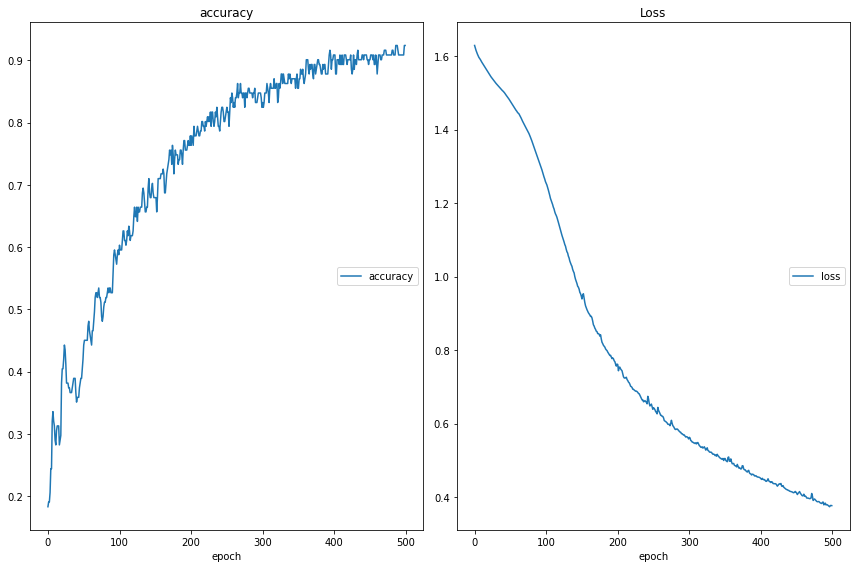

accuracy
	accuracy         	 (min:    0.183, max:    0.924, cur:    0.924)
Loss
	loss             	 (min:    0.374, max:    1.629, cur:    0.377)


In [13]:

model.fit(x, y, 
          batch_size=32, 
          epochs=500, 
          shuffle=True,
          callbacks=[PlotLossesCallback()]
         )

In [14]:
"""*****************************************************LOOK AT THIS ************************************************"""
emoji_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)
              
    
def print_predictions(X, pred):
    for i in range(len(X)):
        print(X[i], label_to_emoji(int(pred[i])))
        
"""******************************************************************************************************"""
def sampling():
    testPath ="./test.csv"
    df=pd.read_csv(testPath) 
    allText=df.iloc[:, 0].tolist()
    for i in range(len(allText)):
        allText[i] = allText[i].lower().replace("\t","").split()
    
    xx = allText
    sequences = tokenizer.texts_to_sequences(xx)
    print("sequences : "+str(sequences))
    
    X_train = pad_sequences(sequences, maxWords)
    yhat =model.predict(X_train)
    
    y_train = to_categorical(df.iloc[:, 1], num_classes=5)  
    print("yhat shape"+str(yhat.shape))
    print("y shape"+str(y_train.shape))
    print("x : "+str(xx))
    
    print_predictions(xx,np.argmax(yhat, axis=1))

    



In [15]:
sampling()

sequences : [[13, 23, 16, 92], [13, 24, 5], [12, 24, 20, 5], [25, 25, 25, 15, 26, 7, 31], [13, 3, 5, 42], [1, 6], [75, 5, 66], [3, 4, 22], [36, 14, 46, 25, 25, 25], [3, 4, 81], [3], [14, 3, 79, 20], [8, 2], [90, 91, 33], [14, 3, 16, 70], [3], [11, 5], [36, 20], [11, 66], [1, 18], [2, 9, 53], [1], [12, 3, 5], [8, 2, 49], [1, 6], [20, 4, 81], [9, 3, 4, 18, 28, 9, 34], [17, 40], [53, 3], [1, 35, 2, 7, 84], [4, 81], [9, 34, 3, 7], [12, 128, 129], [41, 2, 9], [13, 121], [79, 20], [1, 6, 118], [119, 2, 38, 4], [1, 29, 10], [1, 41], [1, 29, 17], [1, 35, 76], [50, 3, 17, 33, 40], [42, 30], [1, 18, 2, 10, 4, 74], [50, 2, 23, 26], [25, 25, 25, 64], [1, 19, 10, 46], [90], [117], [3, 1, 27], [2, 8, 14], [42, 46], [2, 14], [1, 23, 16, 27]]
yhat shape(55, 5)
y shape(55, 5)
x : [['he', 'did', 'not', 'answer'], ['he', 'got', 'a', 'raise'], ['she', 'got', 'me', 'a', 'present'], ['ha', 'ha', 'ha', 'it', 'was', 'so', 'funny'], ['he', 'is', 'a', 'good', 'friend'], ['i', 'am', 'upset'], ['we', 'had', 'such